In [2]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.svm import SVC
from tqdm import tqdm
import matplotlib.pyplot as plt

path = "data/KMeansSMOTE_Y_SelectedFeatures.csv"
df= pd.read_csv(path)
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train.shape

(21518, 85)

In [3]:
path.split("/")[1].split(".")[0]

'KMeansSMOTE_Y_SelectedFeatures'

In [4]:
def createDB():
    with sqlite3.connect("data/models_Reports_WareHouse.db") as conn:
        cursor = conn.cursor()
    
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS TEST_METADATA (
                test_id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                model_name TEXT,
                dataset_name TEXT,
                dataset_version TEXT,
                test_type TEXT,
                notes TEXT
            );
        """)

        cursor.execute("""
            CREATE TABLE IF NOT EXISTS MODEL_PARAMETERS (
                test_id INTEGER,
                hyperparameters TEXT,
                FOREIGN KEY (test_id) REFERENCES TEST_METADATA(test_id)
            );
        """)
    
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS METRICS (
                test_id INTEGER,
                anomaly TEXT,
                normal TEXT,
                accuracy TEXT,
                macro_avg TEXT,
                weighted_avg TEXT,
                FOREIGN KEY (test_id) REFERENCES TEST_METADATA(test_id)
            );
        """)

def  save_REPORT(report:dict , model:BaseEstimator , dataset_version:str , notes:str, test_type:str = "Classification" , dataset_name:str =path.split("/")[1].split(".")[0]):
    with sqlite3.connect("data/models_Reports_WareHouse.db") as conn:
        cursor = conn.cursor()

        cursor.execute("""
            INSERT INTO TEST_METADATA (model_name, dataset_name, dataset_version, test_type, notes)
            VALUES (?, ?, ?, ?, ?)
        """ , (type(model).__name__, dataset_name, dataset_version, test_type, notes)
       )

        # Get the auto-generated test_id
        test_id = cursor.lastrowid

        cursor.execute("""
            INSERT INTO MODEL_PARAMETERS (test_id, hyperparameters)
            VALUES (? , ? )
        """, (test_id,str(model.get_params()))
        )


        cursor.execute("""
            INSERT INTO METRICS (test_id, anomaly, normal, accuracy, macro_avg, weighted_avg)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (
            test_id,
            str(report["anomaly"]),
            str(report["normal"]),
            str(report["accuracy"]),
            str(report["macro avg"]),
            str(report["weighted avg"])
        )
   )

        conn.commit()



In [5]:
from sklearn.metrics import classification_report

def generate_metric_report(y_true:np.array, y_pred:pd.Series ,model:BaseEstimator  , dataset_version:str , notes:str  , test_type:str = "Classification")->pd.DataFrame:

    # Using sklearn's classification report, then converting it to dataframe
    report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True))

    # Excluding last row from scaling by 100.
    report.iloc[:-1, :] = report.iloc[:-1, :] *100

    # Rounding to 2 decimals for each col, also excluding the last row
    for i, col in enumerate(report.columns):
        report.iloc[:-1, i] = report.iloc[:-1, i].apply( lambda v: round(v, 2) )

    # LiteSQL Logic
    save_REPORT(report.to_dict('series'), model , "v1", notes, test_type , )
    
    return report

# Model 1: SVM Classifier

In [7]:
# Reading the *lasso* feature-reduced version of dataset
df= pd.read_csv("data/KMeansSMOTE_O_M_SelectedFeatures.csv")
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Comparing different normalizations parameters and comparing their recall percentage
# we will use "Parallel" and "delayed" from joblib to execute code parallel
from joblib import Parallel, delayed

c_range = np.arange(2.2, 4.7, 0.2)
recalls = []

def try_c_value(c):
    clf_svc = SVC(kernel="linear", C=c)
    clf_svc.fit(X_train, Y_train)
    svc_pred = clf_svc.predict(X_test)
    return generate_metric_report(y_test, svc_pred, clf_svc, "SMOTE_OM", "diffent cs").loc["recall"]["anomaly"]

recalls = Parallel(n_jobs=-1)(delayed(try_c_value)(c) for c in c_range)


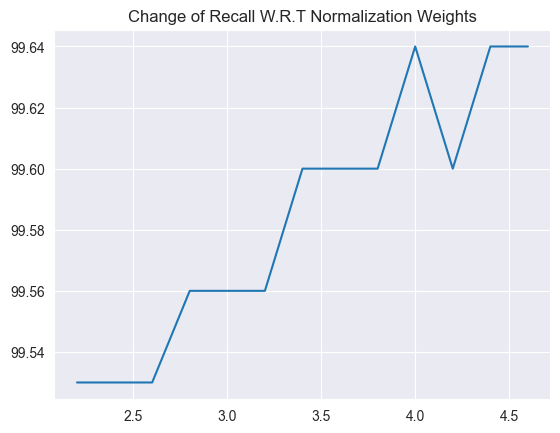

In [8]:
import seaborn as sns
# Visualizing the change of Recall W.R.T normalization weights
sns.lineplot(x=c_range,y= recalls)
plt.title("Change of Recall W.R.T Normalization Weights")
plt.show()

In [9]:
# Using the best normalization parameter
clf_svc = SVC(kernel = "linear", C = 4)
clf_svc.fit(X_train, Y_train)
svc_pred = clf_svc.predict(X_test)
generate_metric_report(y_test,svc_pred ,  model= clf_svc , dataset_version = "OM" , notes = "Final C hyperparam")

anomaly   normal  accuracy  macro avg  weighted avg
precision    99.78    99.58  99.68000      99.68         99.68
recall       99.60    99.77  99.68000      99.69         99.68
f1-score     99.69    99.68  99.68000      99.68         99.68
support    2754.00  2626.00   0.99684    5380.00       5380.00

# Model 2: Decision Tree Classifier

In [10]:
from sklearn.tree import plot_tree, DecisionTreeClassifier

# https://medium.com/data-science/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
dt_clf = DecisionTreeClassifier(
    max_depth=None,           # Maximum depth of the tree
    min_samples_split=2,      # Minimum number of samples required to split an internal node
    min_samples_leaf=1,       # Minimum number of samples required to be at a leaf node
    criterion='entropy'       # Function to measure the quality of a split
)
dt_clf.fit(x_train, y_train)

decisionTree_pred = dt_clf.predict(x_test)

generate_metric_report(y_test,decisionTree_pred ,  model= dt_clf , dataset_version = "v1" , notes = "Test Report")

anomaly   normal   accuracy  macro avg  weighted avg
precision    99.78    99.73  99.760000      99.76         99.76
recall       99.75    99.77  99.760000      99.76         99.76
f1-score     99.76    99.75  99.760000      99.76         99.76
support    2754.00  2626.00   0.997584    5380.00       5380.00

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10), dpi=1000)

plot_tree(dt_clf, filled=True, feature_names=x_test.columns,
          class_names=['Anomaly', 'Normal'], impurity=False)
plt.show()

# Model 3: Random Forest Classifier

In [12]:
# resources:
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
# https://medium.com/data-science/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(
    criterion='entropy'
)
forest.fit(x_train, y_train)
randomForest_pred = forest.predict(x_test)
generate_metric_report(y_test,randomForest_pred ,  model= forest , dataset_version = "v1" , notes = "Testing Random Forest criterion='entropy'")

anomaly   normal   accuracy  macro avg  weighted avg
precision    99.96    99.70  99.830000      99.83         99.83
recall       99.71    99.96  99.830000      99.84         99.83
f1-score     99.84    99.83  99.830000      99.83         99.83
support    2754.00  2626.00   0.998327    5380.00       5380.00

#### Fine Tuning Random Forest Classifier (Not Completed)

In [15]:
# from sklearn.model_selection import GridSearchCV
# rf_grid = RandomForestClassifier()
# gr_space = {
#     'max_depth': [3, 5, 7, 10],
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_features': ["sqrt", "log2", None],
#     'min_samples_leaf': [1, 2, 4, 6, 8, 10],
#     "criterion": ["gini", "entropy", "log_loss"],
#     "bootstrap": [True, False],
#     "oob_score": [True, False],
#     # "random_state":  np.arange(0, 50),
#     "warm_start": [True, False],
#     # "ccp_alpha": np.linspace(0.0, 1.0, 20),
#
# }
#
#
# grid = GridSearchCV(rf_grid, gr_space, cv = 3, scoring='accuracy', verbose = 3 ,n_jobs=-1 )
# model_grid = grid.fit(x_train, y_train)
#
# print('best hyperparameters : '+str(model_grid.best_params_))
# print('best score : ' + str(model_grid.best_score_))

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV

# rf = RandomForestClassifier()


# param_dist = {
#     'n_estimators': [100, 200, 300, 500, 700, 1000],
#     'max_depth': [3, 5, 10, 20, None],
#     'min_samples_leaf': [1, 2, 4, 8],
#     'max_features': ['sqrt', 'log2', None],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'bootstrap': [True, False],
#     'oob_score': [True, False],
#     'random_state': np.arange(0, 100),
#     'warm_start': [True, False],
#     'ccp_alpha': np.linspace(0.0, 1.0, 20)
# }


# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=50,  # Number of parameter settings sampled
#     cv=3,
#     verbose=3,
#     random_state=42,
#     scoring='accuracy',
#     n_jobs=-1  # Use all available cores
# )

# model = random_search.fit(x_train, y_train)

# print('best hyperparameters : '+str(model_grid.best_params_))
# print('best score : ' + str(model_grid.best_score_))
